# Compute confidence interval of importance factors indices using linear regression

This examples shows how to compute confidence bounds of importance factors using the properties of linear regression methods. First, we compute importance factors indices and draw them. Then we compute confidence bounds using methods from linear regression, and draw them.

The bounds are computed using the squared normal distribution is is based on the distribution of the vector of parameters.

In [1]:
import openturns as ot
import openturns.viewer as otv
from math import sqrt
import pylab as pl

We define the function g.

In [2]:
def functionCrue8vars(X):
    Q, Ks, Zv, Zm, Hd, Zb, L, B = X
    Zd = Zb + Hd
    alpha = (Zm - Zv) / L
    H = (Q / (Ks * B * sqrt(alpha))) ** (3.0 / 5.0)
    Zc = H + Zv
    S = Zc - Zd
    return [S]


g = ot.PythonFunction(8, 1, functionCrue8vars)
g.setDescription(["Q", "Ks", "Zv", "Zm", "Hd", "Zb", "L", "B", "S"])

Hd = 8.0
Zb = 55.5
L = 5000.0
B = 300.0
X = [Hd, Zb, L, B]
g_parametric = ot.ParametricFunction(g, [4, 5, 6, 7], X)

Then we define the random vector. 

In [3]:
Q = ot.Gumbel(558.0, 1013.0)
otLOW = ot.TruncatedDistribution.LOWER
Q = ot.TruncatedDistribution(Q, 0, otLOW)
Ks = ot.Normal(30.0, 7.5)
Ks = ot.TruncatedDistribution(Ks, 0, otLOW)
Zv = ot.Uniform(49.0, 51.0)
Zm = ot.Uniform(54.0, 56.0)

X = ot.ComposedDistribution([Q, Ks, Zv, Zm])

We produce a pair of input and output sample.

In [4]:
sampleSize = 100
sampleX = X.getSample(sampleSize)
sampleY = g_parametric(sampleX)

importance_factors = ot.CorrelationAnalysis.SRC(sampleX, sampleY)
print(importance_factors)

[0.378122,0.159565,0.180492,0.00565251]


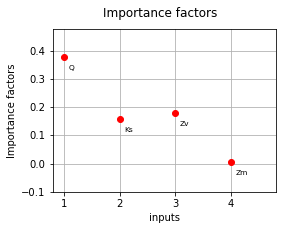

In [5]:
input_names = g_parametric.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
    importance_factors, input_names, "Importance factors"
)
graph.setYTitle("Importance factors")
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.1 + max(importance_factors))

In [6]:
myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
myLeastSquares.run()
responseSurface = myLeastSquares.getMetaModel()
responseSurface

class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=LinearEvaluation name=Unnamed center=class=Point name=Unnamed dimension=4 values=[0,0,0,0] constant=class=Point name=Unnamed dimension=1 values=[-51.7738] linear=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00113853,-0.0669253,1.01919,-0.17428] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=4 columns=1 values=[0.00113853,-0.0669253,1.01919,-0.17428] hessianImplementation=class=ConstantHessian name=Unnamed constant=class=SymmetricTensor implementation=class=TensorImplementation name=Unnamed rows=4 columns=4 sheets=1 values=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [7]:
def define_linear_basis(dimension):
    """
    Compute a basis suitable for linear regression.
    
    This basis corresponds to the linear regression model:
    
    Y = beta[0] + beta[1] * X_1 + ... + beta[p] * X_p
   
    where p is the dimension.
    The first item of this basis corresponds to the intercept, i.e. 
    the function is constant and equal to 1.
    The remaining items are identity function, returning the corresponding 
    input variable.
    
    Parameters
    ----------
    dimension : int
        The number of dimensions of the input variable X.
    
    Returns
    -------
    basis : ot.Basis(1 + dimension)
        The functional basis.
    """
    list_of_inputs = ["x%d" % (i) for i in range(dimension)]
    # The intercept
    basis_list = []
    constant_function = ot.SymbolicFunction(list_of_inputs, ["1"])
    basis_list.append(constant_function)
    # The remaining functions
    for i in range(dimension):
        identity_function = ot.SymbolicFunction(list_of_inputs, ["x%d" % (i)])
        basis_list.append(identity_function)
    basis = ot.Basis(basis_list)
    return basis

In [8]:
def compute_least_squares_parameter_distribution(sampleX, sampleY):
    """
    Compute the gaussian distribution of the beta parameter.
    
    This distribution is valid under the hypothesis that the linear 
    least squares problem has a gaussian residual distribution.
    
    Parameters
    ----------
    sampleX : ot.Sample(size, input_dimension)
        The input sample.
    sampleY : ot.Sample(size, 1)
        The output sample.
    
    Returns
    -------
    distribution_betahat : ot.Normal()
        The gaussian distribution of beta_hat.
    """
    input_dimension = sampleX.getDimension()
    basis = define_linear_basis(input_dimension)
    design_proxy = ot.DesignProxy(sampleX, basis)
    n_parameters = len(basis)
    indices = list(range(n_parameters))
    design_matrix = design_proxy.computeDesign(indices)
    myLeastSquares = ot.LinearLeastSquares(sampleX, sampleY)
    myLeastSquares.run()
    responseSurface = myLeastSquares.getMetaModel()
    predicted_outputs = responseSurface(sampleX)
    residuals_sample = sampleY - predicted_outputs
    residuals_sample.setDescription(["Residuals"])
    residuals_point = residuals_sample.asPoint()
    sample_size = sampleX.getSize()
    sigma2_hat = residuals_point.normSquare() / (sample_size - n_parameters)
    lsq_method = ot.QRMethod(design_proxy, indices)
    observation_point = sampleY.asPoint()
    beta_hat = lsq_method.solve(observation_point)
    inverse_gram = lsq_method.getGramInverse()
    covariance_matrix = ot.CovarianceMatrix(sigma2_hat * inverse_gram)
    distribution_betahat = ot.Normal(beta_hat, covariance_matrix)
    description = [r"$\beta_%d$" % (i) for i in range(n_parameters)]
    distribution_betahat.setDescription(description)
    return distribution_betahat

In [9]:
distribution_betahat = compute_least_squares_parameter_distribution(sampleX, sampleY)
beta_hat = distribution_betahat.getMean()
print("hat(Beta) = ", beta_hat)

hat(Beta) =  [-51.7738,0.00113853,-0.0669253,1.01919,-0.17428]


In [10]:
# Compute quantiles
alpha = 0.05
dimension = sampleX.getDimension()
beta_lower_bound = ot.Point(1 + dimension)
beta_upper_bound = ot.Point(1 + dimension)
# We include the distribution of the intercept
for i in range(1 + dimension):
    marginal_beta_distribution = distribution_betahat.getMarginal(i)
    marginal_beta_bounds = marginal_beta_distribution.computeBilateralConfidenceInterval(
        1.0 - alpha
    )
    beta_lower_bound[i] = marginal_beta_bounds.getLowerBound()[0]
    beta_upper_bound[i] = marginal_beta_bounds.getUpperBound()[0]
beta_bounds = ot.Interval(beta_lower_bound, beta_upper_bound)
print(beta_bounds)

[-60.812, -42.7356]
[0.00103796, 0.0012391]
[-0.0758696, -0.0579811]
[0.896351, 1.14204]
[-0.291698, -0.0568613]


In [11]:
variance_Y = sampleY.computeCovariance()[0, 0]
print("variance_Y = %.3f" % (variance_Y))

variance_Y = 1.880


We are interested in the importance factors :
$$
\eta_i = \frac{\beta_i^2 \mathbb{V}(X_i)}{\mathbb{V}(Y)}
$$
for $i = 1, ..., p$. 

We are estimate these importance factors using the estimator :
$$
\hat{\eta}_i = \frac{\hat{\beta}_i^2 \mathbb{V}(X_i)}{\hat{\sigma}_Y^2}
$$
for $i = 1, ..., p$ where $\hat{\sigma}_Y^2$ is the estimate of the variance of the output. 

In the next cell, we compute the importance factors using the linear regression. We are interested only in the coefficients $\hat{\beta}_1, ..., \hat{\beta}_p$ and not in $\hat{\beta}_0$, which is why we have to use a shift of +1 in the indices. 

In [12]:
importance_factors = ot.Point(dimension)
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    # We shift beta, because we do not consider the intercept here.
    importance_factors[i] = beta_hat[1 + i] ** 2 * variance_X_i / variance_Y
print(importance_factors)

[0.350857,0.133918,0.184145,0.00538444]


We observe that parts of the estimator 
$$
\hat{\eta}_i = \frac{\hat{\beta}_i^2 \mathbb{V}(X_i)}{\hat{\sigma}_Y^2}
$$
for $i = 1, ..., p$ have a known distribution. Indeed, the marginal distribution of $\hat{\beta}_i$ is known, using properties of the linear regression model.

We recognize that if $\hat{\beta}_i \sim \mathcal{N}\left(\mu_{\hat{\beta}_i}, \sigma_{\hat{\beta}_i}^2\right)$, then $\hat{\beta}_i^2$ has a [noncentral chi-squared distribution with one degree of freedom](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution). More precisely, the random variable $\frac{\hat{\beta}_i}{\sigma_{\hat{\beta}_i}}$ is $\mathcal{N}(\mu_{\hat{\beta}_i}, 1)$, which implies that $\left(\frac{\hat{\beta}_i}{\sigma_{\hat{\beta}_i}}\right)^2$ has a noncentral chi-squared distribution with a non centrality parameter $\lambda = \left(\frac{\mu_{\hat{\beta}_i}}{\sigma_{\hat{\beta}_i}}\right)^2$. 

The variable $\hat{\beta}_i^2$ is a chi-squared distribution if $\mu_{\hat{\beta}_i} = 0$ and $\sigma_{\hat{\beta}_i}^2 = 1$. This is unlikely to happen, since we consider a coefficient $\hat{\beta}$ which mean is not necessarily zero and variance is not necessarily equal to 1. 

The distribution of $\hat{\sigma}_Y^2$ is a little more complicated to compute. We known that :
$$
\textrm{V}(Y) = \beta_1^2 \mathbb{V}(X_1) + ... + \beta_p^2 \mathbb{V}(X_p) + \mathbb{V}(\epsilon).
$$
Hence,
$$
\hat{\sigma}_Y^2 = \hat{\beta}_1^2 \mathbb{V}(X_1) + ... + \hat{\beta}_p^2 \mathbb{V}(X_p) + \hat{\sigma}_\epsilon^2.
$$
The distribution of $\hat{\beta}_1^2 \mathbb{V}(X_1) + ... + \hat{\beta}_p^2 \mathbb{V}(X_p)$ is a sum of squared gaussian random variables. The distribution of $\hat{\sigma}_\epsilon^2$ is less easy to compute. 

We may compute the distribution of $\hat{\beta}_i^2$ using the arithmetic of distributions, which leads to a `SquaredNormal` distribution. 

Let:
$$
Z_i = \hat{\beta}_i^2 \mathbb{V}(X_i)
$$
for $i = 1, ..., p$.
Therefore, we are interested in the distribution of :
$$
\hat{\eta}_i = \frac{Z_i}{Z_1 + ... + Z_p + \hat{\sigma}_\epsilon^2}.
$$
We notice that the variables $Z_i$ and $Z_1 + ... + Z_p$ are not independent. 

In the following calculation, we make the approximation :
$$
\hat{\eta}_i \approx \frac{Z_i}{Z_1 + ... + Z_p}
$$
i.e. we assume that the distribution of $\hat{\sigma}_\epsilon^2$ can be neglected. This tends to reduce the variability of the importance factors and may lead to smaller confidence intervals. 

Furthermore, we assume that the random variables $Z_1, ..., Z_p$ are independent. This must increase the variability of the ratio and may lead to larger confidence intervals. 

In the next cel, we create a list with the list of distributions of $Z_1, ..., Z_p$. 

In [13]:
Z_distribution_list = []
for i in range(dimension):
    marginal_input_distribution = X.getMarginal(i)
    variance_X_i = marginal_input_distribution.getCovariance()[0, 0]
    marginal_beta_distribution = distribution_betahat.getMarginal(1 + i)
    # Use the arithmetic of distributions
    Z_i_distribution = marginal_beta_distribution ** 2 * variance_X_i
    print(Z_i_distribution)
    Z_distribution_list.append(Z_i_distribution)

RandomMixture(508950 * SquaredNormal(mu = 0.00113853, sigma = 5.13115e-05))
RandomMixture(56.2199 * SquaredNormal(mu = -0.0669253, sigma = 0.00456347))
RandomMixture(0.333333 * SquaredNormal(mu = 1.01919, sigma = 0.0626759))
RandomMixture(0.333333 * SquaredNormal(mu = -0.17428, sigma = 0.0599084))


We see that the product of a constant and a `SquaredNormal` is not simplified into a `SquaredNormal`. This is a simplification that could be done by the software. 

Then we create the random variable associated with the variable $Z_1 + ... + Z_p$, using the arithmetic of distributions. 

In [14]:
variance_Y_distribution = Z_distribution_list[0]
for i in range(1, dimension):
    variance_Y_distribution += Z_distribution_list[i]
variance_Y_distribution

class=RandomMixture name=RandomMixture distribution collection=[class=SquaredNormal name=SquaredNormal mu=0.00113853 sigma=5.13115e-05,class=SquaredNormal name=SquaredNormal mu=-0.0669253 sigma=0.00456347,class=SquaredNormal name=SquaredNormal mu=1.01919 sigma=0.0626759,class=SquaredNormal name=SquaredNormal mu=-0.17428 sigma=0.0599084] weights =class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=4 values=[508950,56.2199,0.333333,0.333333] constant=class=Point name=Unnamed dimension=1 values=[0]

Finally, we compute the confidence bound, using again the arithmetic of distributions in order to define the ratio $\frac{Z_i}{Z_1 + ... + Z_p}$. We finally create a random vector with independent marginals, with the `ComposedDistribution` class. 

In [15]:
eta_i_distribution_list = []
for i in range(dimension):
    eta_i_distribution = Z_distribution_list[i] / variance_Y_distribution
    eta_i_distribution_list.append(eta_i_distribution)
eta_distribution = ot.ComposedDistribution(eta_i_distribution_list)

In [16]:
importance_factors_lower_bound = ot.Point(dimension)
importance_factors_upper_bound = ot.Point(dimension)
for i in range(dimension):
    eta_i_distribution = eta_distribution.getMarginal(i)
    marginal_bounds = eta_i_distribution.computeBilateralConfidenceInterval(1.0 - alpha)
    importance_factors_lower_bound[i] = marginal_bounds.getLowerBound()[0]
    importance_factors_upper_bound[i] = marginal_bounds.getUpperBound()[0]
importance_factors_bounds = ot.Interval(
    importance_factors_lower_bound, importance_factors_upper_bound
)
print(importance_factors_bounds)

[0.415953, 0.64203]
[0.0763505, 0.0763505]
[0.205061, 0.353892]
[0.000847672, 0.0225222]


In [17]:
def plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_bounds
):
    """
    Plot importance factors indices with confidence bounds of level 1 - alpha
    
    Parameters
    ----------
    importance_factors : ot.Point(dimension)
        The importance factors.
    input_names : list(str)
        The names of the input variables.
    alpha : float, in [0, 1]
        The complementary confidence level.
    importance_bounds : ot.Interval(dimension)
        The lower and upper bounds of the importance factors
    
    Returns
    -------
    graph : ot.Graph
        The importance factors indices with lower and upper 1-alpha confidence intervals.
    """
    dim = importance_factors.getDimension()
    lowerBounds = importance_bounds.getLowerBound()
    upperBounds = importance_bounds.getUpperBound()
    graph = ot.SobolIndicesAlgorithm.DrawCorrelationCoefficients(
        importance_factors, input_names, "Importance factors"
    )
    graph.setYTitle("Importance factors")
    title = "Importance factors with bounds at %.2f %%" % ((1 - alpha) * 100)

    graph.setTitle(title)
    # Add confidence bounds
    for i in range(dim):
        curve = ot.Curve([1 + i, 1 + i], [lowerBounds[i], upperBounds[i]])
        graph.add(curve)
    return graph

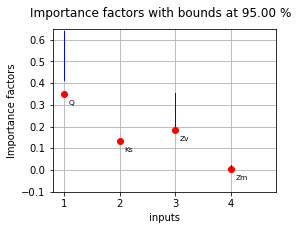

In [19]:
graph = plot_importance_factors_with_bounds(
    importance_factors, input_names, alpha, importance_factors_bounds
)
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})
_ = pl.ylim(top=0.3 + max(importance_factors))

We notice that the bounds are different from than what we may expect. The confidence bound for the variable $K_s$ is very small. This might be the consequence of the fact that we have lost some of the variance considering that $\hat{\sigma}_Y^2$ is not random.

The confidence bounds for some variables do not contain the estimator, especially for $Q$. This might be because we considered the numerator independent from the denominator in the distribution of $\eta_Q$. 

One of the ways to explore this topic further would be to use the delta-method to estimate the asymptotic distribution of $\eta_i$. This might be interesting because we generally estimate these coefficients using relatively large sample sizes, typically with $n > 100$. Hence, the asymptotic assumption might be valid in this case.